In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [5]:
# import dataset bid and bidder
bids = pd.read_csv('../Data/facebook/bids.csv')
bidder = pd.read_csv('../Data/facebook/train.csv')

In [6]:
for feature in bids.columns:
    if bids[feature].dtype == 'object':
        print(f"Feature: {feature} has {len(bids[feature].unique())} unique values")

Feature: bidder_id has 6614 unique values
Feature: auction has 15051 unique values
Feature: merchandise has 10 unique values
Feature: device has 7351 unique values
Feature: country has 200 unique values
Feature: ip has 2303991 unique values
Feature: url has 1786351 unique values


In [8]:
for feature in bidder.columns:
    if bidder[feature].dtype == 'object':
        print(f"Feature: {feature} has {len(bidder[feature].unique())} unique values")

Feature: bidder_id has 2013 unique values
Feature: payment_account has 2013 unique values
Feature: address has 2013 unique values


In [9]:
def encoder(df, exclude=None):
    df_encoded = df.copy()

    for column in df_encoded.columns:
        if df_encoded[column].dtype == 'object' and column not in exclude:  
            le = LabelEncoder()
            df_encoded[column] = le.fit_transform(df_encoded[column])

    return df_encoded

In [10]:
bids_encoded = encoder(bids.drop(['ip', 'url'], axis = 1), ['bidder_id'])
bids_encoded['country'].fillna(bids_encoded['country'].mode()[0], inplace=True)

In [11]:
bidder_encoded = encoder(bidder, ['bidder_id'])

In [12]:
X_bidder = bidder_encoded.drop(['outcome'], axis=1)
y_bidder = bidder_encoded['outcome']

X_train, X_test, y_train, y_test = train_test_split(X_bidder, y_bidder, random_state=42, stratify=y_bidder)

bidder_train_df = pd.concat([X_train, y_train], axis=1)
bidder_test_df = pd.concat([X_test, y_test], axis=1)

In [13]:
df_train = pd.merge(bids_encoded, bidder_train_df, on='bidder_id', how='inner')  # Use 'inner' to avoid nans values
df_test = pd.merge(bids_encoded, bidder_test_df, on='bidder_id', how='inner')  # Use 'inner' to avoid nans values

In [14]:
df_train.drop(['bid_id'], axis= 1, inplace=True)
df_test.drop(['bid_id'], axis= 1, inplace=True)

In [15]:
le = LabelEncoder()
all_data = pd.concat([df_train['bidder_id'], df_test['bidder_id']])
le.fit_transform(all_data)
df_train['bidder_id'] = le.transform(df_train['bidder_id'])
df_test['bidder_id'] = le.transform(df_test['bidder_id'])

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    498431
         1.0       1.00      1.00      1.00     90738

    accuracy                           1.00    589169
   macro avg       1.00      1.00      1.00    589169
weighted avg       1.00      1.00      1.00    589169



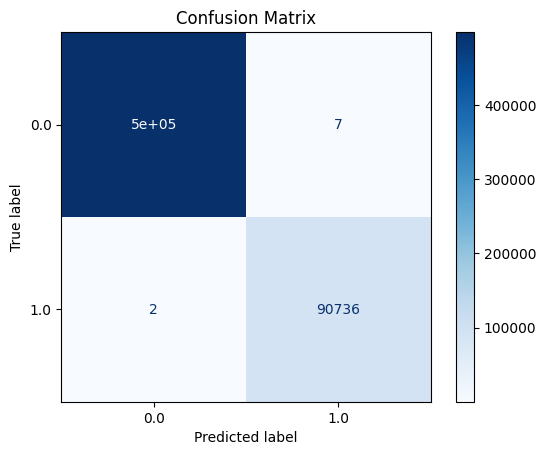

In [21]:
X = df_train.drop(['outcome'], axis=1)
y = df_train['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

rf = DecisionTreeClassifier()

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_pred))
disp.plot(cmap=plt.cm.Blues)

plt.title('Confusion Matrix')
plt.show()



Probabilmente sta overfittando sui bidder che conosce come scam, proviamolo con il test set, mi aspetto un risultato molto basso

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94    665084
         1.0       0.04      0.03      0.03     49465

    accuracy                           0.89    714549
   macro avg       0.49      0.49      0.49    714549
weighted avg       0.87      0.89      0.88    714549



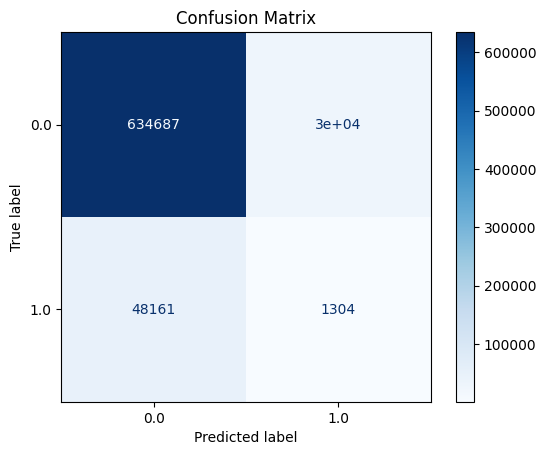

In [22]:
X = df_test.drop(['outcome'], axis=1)
y = df_test['outcome']

y_pred = rf.predict(X)
print("Classification Report:")
print(classification_report(y, y_pred))

cm = confusion_matrix(y, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_pred))
disp.plot(cmap=plt.cm.Blues)

plt.title('Confusion Matrix')
plt.show()


Come ci si aspettava, non è stato in grado di riconoscere i bot. Questo perchè le feature presenti nei dataset non astraggono dal bidder. <br>
L'obiettivo è quello di far imparare il modello a classificare correttamente bot e non bot usando delle feature che astraggano dal bbider